### Lets get some baseline accuracy numbers for this datasets using some `silly` predictive models


In [47]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
import re


# More imports for our traditional machine learning
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load env vars
load_dotenv(override=True)
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
hf_token=os.getenv("HUGGINGFACE_API_KEY")
login(hf_token, add_to_git_credential=True)

In [10]:
# Read the data
with open('./data/train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('./data/test.pkl', 'rb') as file:
    test = pickle.load(file)

#### 1. Silly predictor - predicts a random price

- i am writing this predictor to help me write a class which takes in a predictor and gives a report on its performance


In [6]:
type(train), len(train), type(test), len(test)

(list, 73000, list, 723)

In [41]:
def random_predictor(test):
    return [random.randint(0,100) for sample in test]

In [11]:
def run_test(prediction_fn, test_set=test):
    y_pred = prediction_fn(test)
    y_true = [sample.price for sample in test]
    error = mean_squared_error(y_true, y_pred)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate percentage error
    deviation = np.abs(y_true - y_pred) / (y_true + 1e-8)  # small value to avoid division by zero

    # Determine colors
    colors = []
    for d in deviation:
        if d <= 0.1:
            colors.append("#103928")
        elif d <= 0.5:
            colors.append("#71a892")
        else:
            colors.append("#fda287")

    within_10_pct = (len([x for x in colors if x=="#103928"]))/ len(colors) * 100
    btw_10_50= (len([x for x in colors if x=="#71a892"]))/ len(colors) * 100
    rest = (len([x for x in colors if x=="#fda287"]))/len(colors) * 100
    
    # Plot
    fig, ax = plt.subplots(figsize=(6, 6), layout='constrained')
    ax.scatter(y_true, y_pred, c=colors, s=5)
    ax.plot(np.linspace(0, max(y_true), 1000),
            np.linspace(0, max(y_true), 1000),
            color='red', linestyle='--', label='Perfect Prediction')
    
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    
    ax.set_xlabel('y_true')
    ax.set_ylabel('y_pred')
    ax.set_title(f'{prediction_fn.__name__[:-10]}, MSE: {round(error)}\n within 10%: {within_10_pct:.0f}%, 10-50%: {btw_10_50:.0f}%, >50%: {rest:.0f}%')
    # ax.legend()
    plt.show()

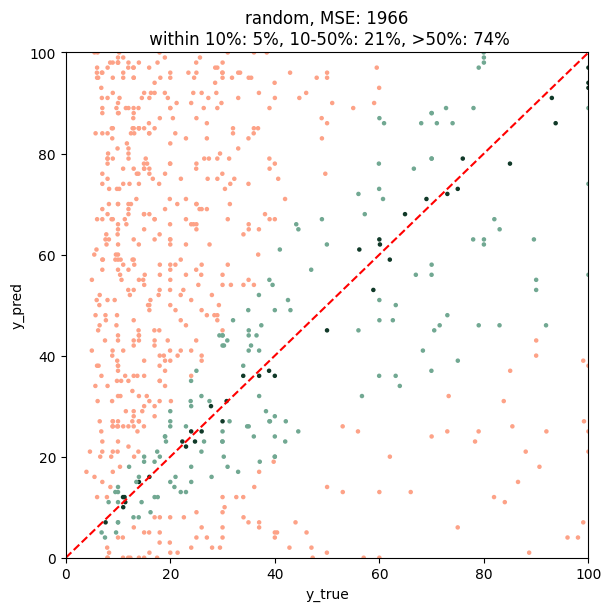

In [196]:
run_test(random_predictor, test)

#### 2. Average predictor


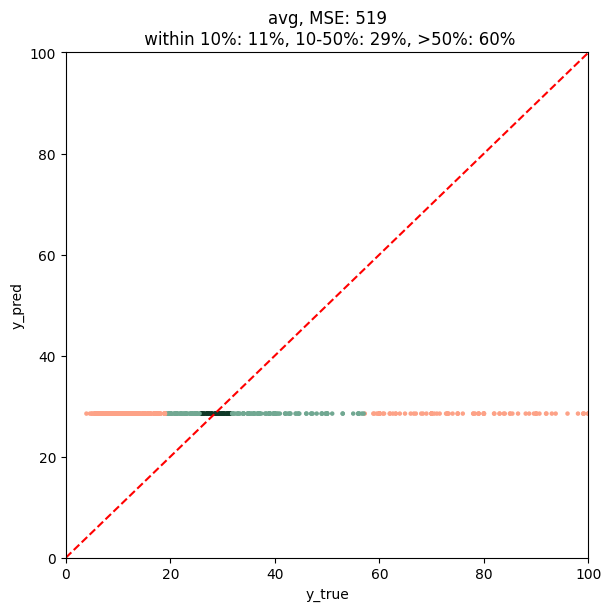

In [197]:
def avg_predictor(test):
    test_mean = np.mean([item.price for item in test])
    return [test_mean for item in test]

run_test(avg_predictor, test)

#### 3. Linear Regression


In [71]:
json.loads(train[0].details)

{'Manufacturer': 'Gchee',
 'Item Weight': '5.6 ounces',
 'Package Dimensions': '4.7 x 4.2 x 1.4 inches',
 'Style': 'Heavy Duty',
 'Material': 'Aluminum',
 'Batteries Included?': 'No',
 'Batteries Required?': 'No',
 'Best Sellers Rank': {'Musical Instruments': 33307, 'Stage Lights': 657},
 'Date First Available': 'May 20, 2019'}

In [ ]:
# Most commonly occuring features

dicts = [json.loads(item.details) for item in train]
key_freq = Counter()
for d in dicts:
    key_freq.update(d.keys())

print(key_freq.most_common(40))

[('Date First Available', 69135), ('Best Sellers Rank', 61321), ('Item Weight', 61070), ('Item model number', 51410), ('Brand', 45441), ('Product Dimensions', 36860), ('Is Discontinued By Manufacturer', 30830), ('Color', 30455), ('Manufacturer', 27251), ('Package Dimensions', 25264), ('Color Name', 24435), ('Material', 22952), ('Material Type', 19352), ('Part Number', 17810), ('Country of Origin', 17254), ('Batteries Required?', 15694), ('Size', 15387), ('Batteries Included?', 13060), ('Item Dimensions LxWxH', 11213), ('Compatible Devices', 11127), ('Style', 11018), ('Included Components', 10471), ('Special Feature', 8561), ('Power Source', 7805), ('Connector Type', 7550), ('Item Package Quantity', 6471), ('Shape', 6016), ('Brand Name', 5927), ('Number of Strings', 5034), ('Unit Count', 4814), ('Body Material', 4771), ('Model Name', 4736), ('Number of Pieces', 4729), ('Finish Type', 4616), ('Domestic Shipping', 4481), ('International Shipping', 4481), ('Connectivity Technology', 4069),

##### Lets choose these as our features, we need to study and tidy up quite a bit for each of the features

1. Item Weight
2. Brand Name
3. Country of Origin
4. Item Dimensions LxWxH
5. Best Sellers Rank
6. Batteries Required?


In [ ]:
# quick check to find types of values we are dealing with - i can write a function to move everythning to same unit based on this.
def t1(v):
    if v is None:
        return None
    return v.split(" ")[1]
t = [t1(json.loads(x.details).get('Item Weight')) for x in train]
print(set(t))

{None, 'Ounces', 'Milligrams', 'pounds', 'Kilograms', 'Pounds', 'ounces', 'Hundredths', 'Grams'}


In [ ]:
def to_grams(value):
    if value is None or not isinstance(value, str):
        return None

    value = value.strip().lower()

    # Try to extract the numeric part
    parts = value.split()
    try:
        number = float(parts[0])
        unit = parts[1] if len(parts) > 1 else None
    except (ValueError, IndexError):
        return None

    # Conversion rules
    conversion_factors = {
        'ounce': 28.3495,
        'ounces': 28.3495,
        'pound': 453.592,
        'pounds': 453.592,
        'kilogram': 1000,
        'kilograms': 1000,
        'gram': 1,
        'grams': 1,
        'mg': 1e-3,
        'milligram': 1e-3,
        'milligrams': 1e-3,
    }

    if unit in conversion_factors:
        return round(number * conversion_factors[unit], 2)
    else:
        return None  # Unknown or unsupported unit

weights_grams = [to_grams(json.loads(x.details).get('Item Weight')) for x in train]

In [127]:
weights_grams[:10]

[158.76, 19.99, 75.98, None, 1310.88, 1288.2, 453.59, 99.79, None, 90.72]

In [ ]:
# since most of the brand names are missing - i decided to use Boolean to indicate if a product is branded or not.
is_branded = [json.loads(x.details).get('Brand Name') is not None for x in train]

In [ ]:
# the first key gives rank in overall category and second key gives ranking in specific category. 
# some details have empty dictionary

def get_rank(product):
    if product is None:
        return None
    else:
        try:
            return list(product.values())[0]
        except:
            return None 

product_rank = [get_rank(json.loads(x.details).get('Best Sellers Rank')) for x in train]

In [ ]:
import re
from typing import Optional

def extract_volume_in_cubic_inches(s: Optional[str]) -> Optional[float]:
    if not isinstance(s, str):
        return None

    # Lowercase and split on ";" to remove trailing weight
    s = s.lower().split(';')[0]

    # Match numbers followed optionally by " or a unit
    matches = re.findall(r'(\d*\.?\d+)(?=\s*["\'″”]*\s*[lwhdxyz]?\s*[x×]?)', s)

    # Fallback: try numbers before "inches"
    if len(matches) < 2:
        matches = re.findall(r'(\d*\.?\d+)', s.split("inches")[0])

    dims = list(map(float, matches[:3]))  # take first 3 numbers

    if len(dims) == 3:
        length, width, height = dims
        return round(length * width * height, 2)
    else:
        return None
    
product_volume = [extract_volume_in_cubic_inches(json.loads(x.details).get('Product Dimensions')) for x in train]

In [ ]:
X = pd.DataFrame({
    "weight": weights_grams,
    "volume": product_volume,
    "rank": product_rank,
    "is_branded": is_branded
})

y = [x.price for x in train]

# i could use train to split out a validation set for model training - once finetuned, predict against test set above
# but i prefer to use cross validations and have it manage the holdout set for validation - this way i train on more data and escape generalization errors too
# so for CV i dont need any splitting at all then 

In [187]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

# Automatically detect numeric and categorical columns
num_features = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_features = X.select_dtypes(include=["bool", "object", "category"]).columns.tolist()

# Numeric pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    # ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="if_binary"))
])

# Combine into column transformer
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Final pipeline
model_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

# Cross-validation
scores = cross_val_score(model_pipeline, X, y, cv=5, scoring="neg_mean_squared_error")

print("MSE per fold:", -scores)
print("Average MSE:", -scores.mean())

# Fit the full model on all available training data
model_pipeline.fit(X, y)

MSE per fold: [724.78422357 519.11580883 516.06146237 512.4199411  548.1362659 ]
Average MSE: 564.1035403526041


,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


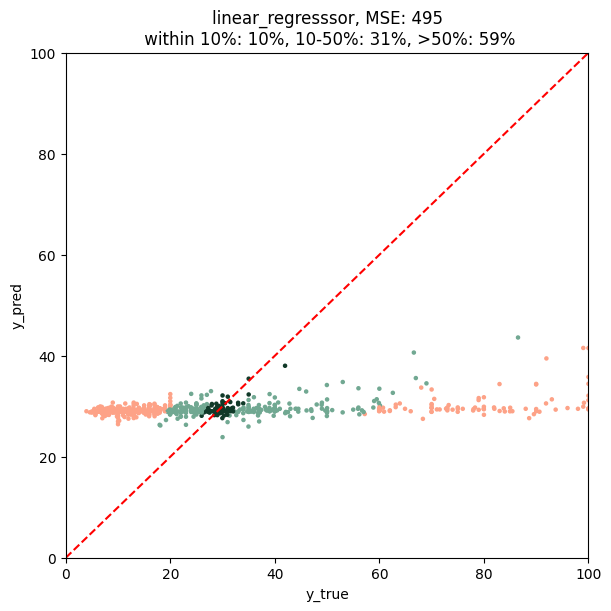

In [198]:
def linear_regresssor_predictor(test):
    weights_grams_test = [to_grams(json.loads(x.details).get('Item Weight')) for x in test]
    is_branded_test = [json.loads(x.details).get('Brand Name') is not None for x in test]
    product_rank_test = [get_rank(json.loads(x.details).get('Best Sellers Rank')) for x in test]
    product_volume_test = [extract_volume_in_cubic_inches(json.loads(x.details).get('Product Dimensions')) for x in test]
    X_test = pd.DataFrame({
        "weight": weights_grams_test,
        "volume": product_volume_test,
        "rank": product_rank_test,
        "is_branded": is_branded_test
    })
    
    return model_pipeline.predict(X_test) 

run_test(linear_regresssor_predictor, test)

#### 4. Bag of words


In [203]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [205]:
# Use the CountVectorizer for a Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


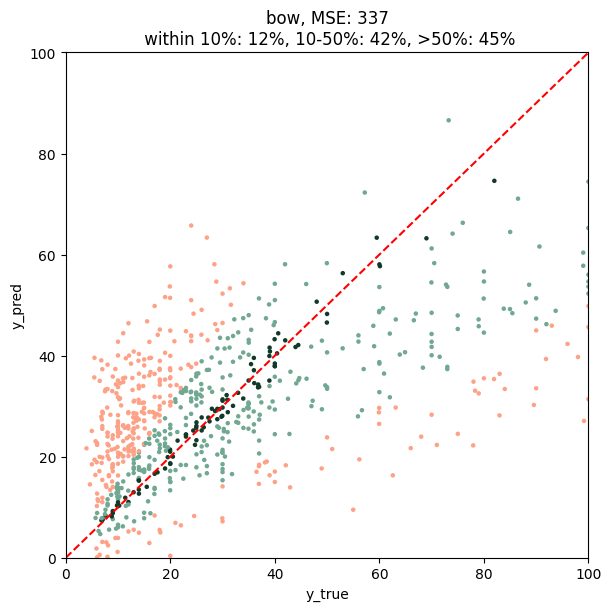

In [215]:
def bow_predictor(test):
    documents = [item.test_prompt() for item in test]
    x_test = vectorizer.transform(documents)
    return regressor.predict(x_test)

run_test(bow_predictor, test)

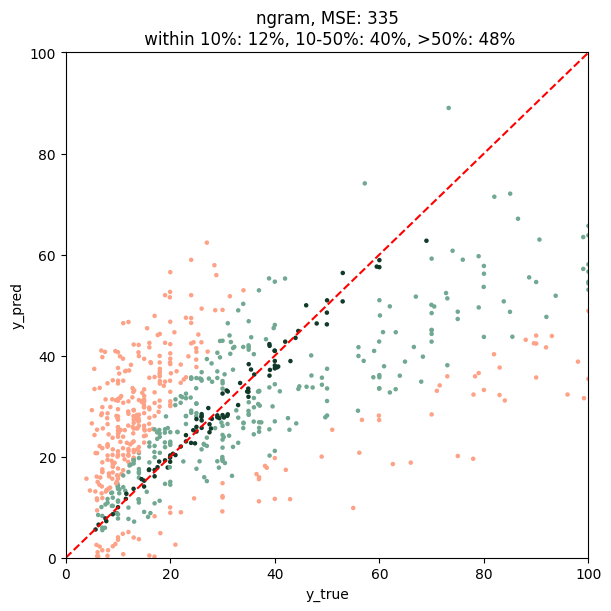

In [216]:
# since this is so promicing (see the distribution of responces), lets try n-grams

vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

def ngram_predictor(test):
    documents = [item.test_prompt() for item in test]
    x_test = vectorizer.transform(documents)
    return regressor.predict(x_test)

run_test(ngram_predictor, test)

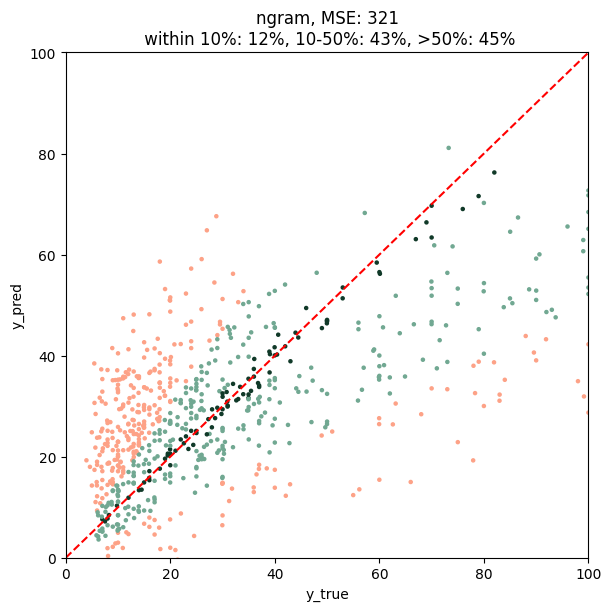

In [217]:

vectorizer = CountVectorizer(max_features=2000, ngram_range=(1,3), stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

def ngram_predictor(test):
    documents = [item.test_prompt() for item in test]
    x_test = vectorizer.transform(documents)
    return regressor.predict(x_test)

run_test(ngram_predictor, test)

#### 5. Word2Vec models (gently forraying to NLP to see if these beat traditional methods for our problem)


In [58]:
# NLP related imports

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [59]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
documents = [item.test_prompt() for item in test]
processed_docs = [simple_preprocess(doc, deacc=True,) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [60]:
# This step of averaging vectors across the document is a weakness in this approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [246]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


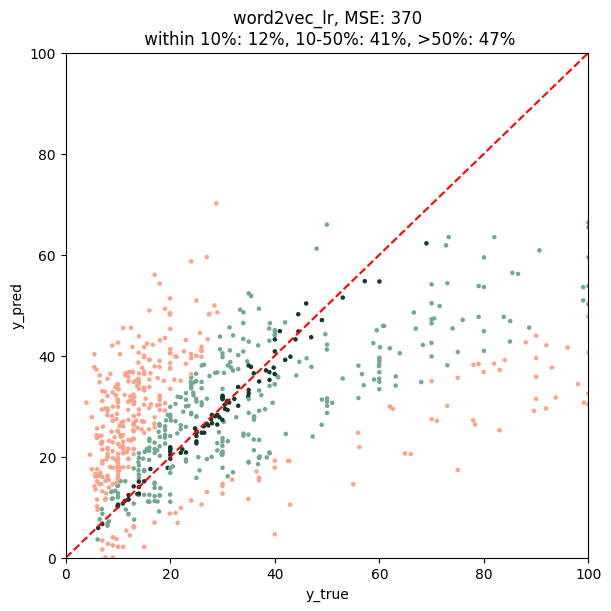

In [248]:
def word2vec_lr_predictor(test):
    doc_vector = [document_vector(item.test_prompt()) for item in test]
    return word2vec_lr_regressor.predict(doc_vector)

run_test(word2vec_lr_predictor, test)

In [62]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

for model in [Ridge(), RandomForestRegressor(n_jobs=-1), GradientBoostingRegressor()]:
    scores = cross_val_score(model, X_w2v, [item.price for item in test], cv=3, scoring='neg_mean_squared_error')
    print(model.__class__.__name__, "MSE:", -scores.mean())

Ridge MSE: 503.25872802734375
RandomForestRegressor MSE: 503.93728219347145
GradientBoostingRegressor MSE: 509.56359906298144


#### 6. OpenAI models to predict prices

- Model might have allready scraped this dataset, so i am going to take this with a pinch of salt and wont rely on it generalizing, i am just curious to see how it performs.
- There is going to be no fine-tuning at this step, so ill directly use the test dataset


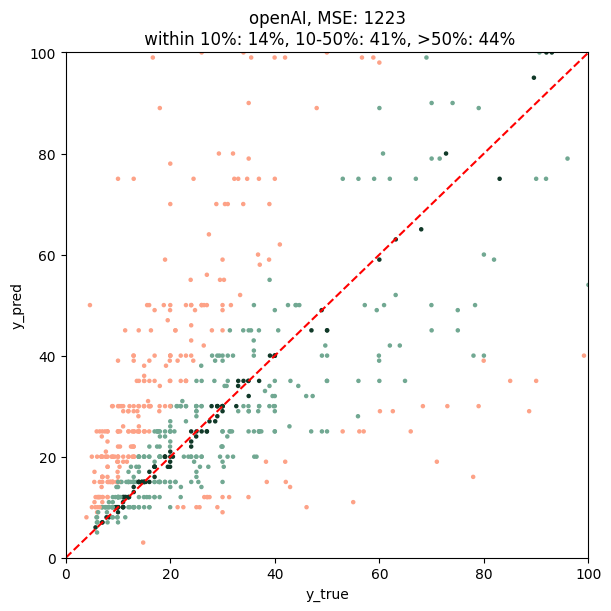

In [ ]:
client = OpenAI()

# A utility function to extract the price from a string as model can return responce in unpredictable way.
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

# ideally i would have used batch API for tasks like these as i can poll an API to see when jobs are completed and its 50% cheaper and asych! but i was eager to see how the models perform. 
def openAI_predictor(test):
    y_pred = []
    prompts = [item.test_prompt() for item in test]
    for prompt in prompts:
        messages=[
            {"role": "developer", "content": "You estimate the price of items. Reply only with price in USD no descriptions or currency symbols, just the number."},
            {"role": "user", "content": prompt[:-12]},
            {"role": "assistant", "content": prompt[-10:]}
        ]
    
        completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        max_tokens=5
        )
        final_price = get_price(completion.choices[0].message.content)
        y_pred.append(final_price)
    
    return y_pred

run_test(openAI_predictor, test)

[40.0]

10.99